In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.25)
plt.rcParams["figure.figsize"] = [8, 6]

In [43]:
data = pd.read_csv('timings_agg.csv')
categories = pd.read_csv("../../2phase_nsa/categories/statsceb_categories.csv")[["query","well_behaved"]].set_index("query")
data = pd.merge(data, categories, left_on="query", right_index=True)
data

,query,method,duration(s)_mean,duration(s)_median,hashjoin_time(s)_mean,hashjoin_time(s)_median,well_behaved
0,1,DF-Bin,0.001155,0.001115,0.001047,0.001016,True
143,1,SYA,0.000747,0.000742,0.000647,0.000644,True
286,1,DuckDB-Bin,0.000633,0.000632,0.000480,0.000481,True
1,2,DF-Bin,0.144960,0.144696,0.142855,0.142590,True
144,2,SYA,0.018891,0.018862,0.017166,0.017139,True
...,...,...,...,...,...,...,...
284,145,SYA,0.011219,0.011108,0.007271,0.007217,False
335,145,DuckDB-Bin,0.041776,0.042258,0.036490,0.036962,False
142,146,DF-Bin,0.026471,0.026405,0.022552,0.022508,False
285,146,SYA,0.032506,0.032553,0.028238,0.028308,False


In [44]:
# Create one table for each method (DuckDB-Bin, DF-Bin, SYA)
df_bin = data[data["method"] == "DF-Bin"].drop(columns=["method"]).set_index("query")
sya = data[data["method"] == "SYA"].drop(columns=["method"]).set_index("query") 
duckdb_bin = data[data["method"] == "DuckDB-Bin"].drop(columns=["method"]).set_index("query") 

In [45]:
merged = pd.merge(
    pd.merge(duckdb_bin,df_bin, on="query", suffixes=("_duckdbbin", "_dfbin")),
    sya.add_suffix("_sya"), on="query"
).drop(columns=["well_behaved_duckdbbin", "well_behaved_dfbin"]).rename(columns={"well_behaved_sya": "well_behaved"})
merged

,duration(s)_mean_duckdbbin,duration(s)_median_duckdbbin,hashjoin_time(s)_mean_duckdbbin,hashjoin_time(s)_median_duckdbbin,duration(s)_mean_dfbin,duration(s)_median_dfbin,hashjoin_time(s)_mean_dfbin,hashjoin_time(s)_median_dfbin,duration(s)_mean_sya,duration(s)_median_sya,hashjoin_time(s)_mean_sya,hashjoin_time(s)_median_sya,well_behaved
query,,,,,,,,,,,,,
1,0.000633,0.000632,0.000480,0.000481,0.001155,0.001115,0.001047,0.001016,0.000747,0.000742,0.000647,0.000644,True
2,0.160787,0.161075,0.158196,0.158730,0.144960,0.144696,0.142855,0.142590,0.018891,0.018862,0.017166,0.017139,True
3,0.107722,0.107446,0.105821,0.105548,0.021759,0.021765,0.019512,0.019558,0.005443,0.005412,0.003275,0.003255,True
4,0.017386,0.017426,0.015611,0.015609,0.019939,0.019915,0.018830,0.018818,0.005679,0.005645,0.004437,0.004430,True
5,0.404405,0.406639,0.401814,0.404052,0.070732,0.069803,0.067254,0.066524,0.015824,0.015700,0.012538,0.012442,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,7.050315,7.261724,6.988004,7.197121,5.132936,5.134273,5.092906,5.094812,2.143622,2.145800,2.121184,2.123063,False
143,16.841304,16.443447,16.823596,16.424858,4.018366,3.974902,3.991139,3.948167,0.634139,0.635128,0.618966,0.619863,False
144,0.409728,0.412778,0.403060,0.406124,0.338679,0.338933,0.332521,0.332772,0.088473,0.088408,0.085586,0.085530,True


In [46]:
# median and average runtimes
mean_median = pd.DataFrame({
    "median": merged.median(axis=0),
    "mean": merged.mean(axis=0)}
)
mean_median

,median,mean
duration(s)_mean_duckdbbin,0.056530,4.113531
duration(s)_median_duckdbbin,0.056502,4.102561
hashjoin_time(s)_mean_duckdbbin,0.055363,4.099730
hashjoin_time(s)_median_duckdbbin,0.055421,4.088764
duration(s)_mean_dfbin,0.023053,1.185921
duration(s)_median_dfbin,0.023155,1.184740
hashjoin_time(s)_mean_dfbin,0.019540,1.176181
hashjoin_time(s)_median_dfbin,0.019657,1.175123
duration(s)_mean_sya,0.010182,0.202642
duration(s)_median_sya,0.010141,0.202307


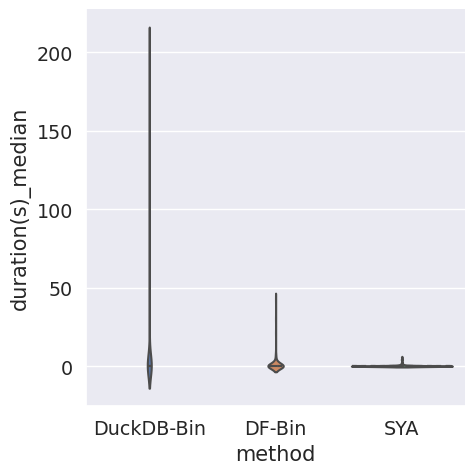

In [47]:
methods_order = ["DuckDB-Bin", "DF-Bin", "SYA"]
sns.catplot(data=data, x="method", y="duration(s)_median", order=methods_order, kind="violin", inner="quart")

In [48]:
mean_median.loc[mean_median.index.str.startswith("duration(s)_median")][["mean"]].transpose()

,duration(s)_median_duckdbbin,duration(s)_median_dfbin,duration(s)_median_sya
mean,4.102561,1.18474,0.202307


In [49]:
mean_median.loc[mean_median.index.str.startswith("duration(s)_median")][["median"]].transpose()

,duration(s)_median_duckdbbin,duration(s)_median_dfbin,duration(s)_median_sya
median,0.056502,0.023155,0.010141


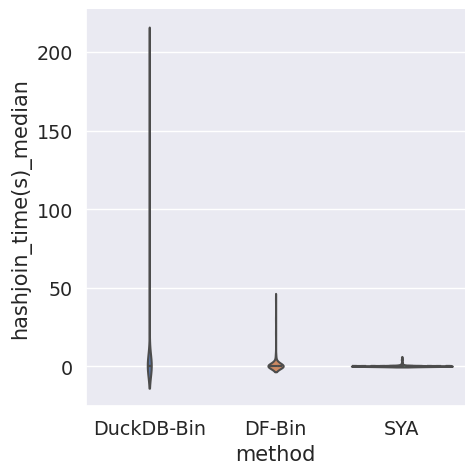

In [50]:
sns.catplot(data=data, x="method", y="hashjoin_time(s)_median", order=methods_order, kind="violin", inner="quart")

In [51]:
mean_median.loc[mean_median.index.str.startswith("hashjoin_time(s)_median")][["mean"]].transpose()

,hashjoin_time(s)_median_duckdbbin,hashjoin_time(s)_median_dfbin,hashjoin_time(s)_median_sya
mean,4.088764,1.175123,0.19708


In [52]:
mean_median.loc[mean_median.index.str.startswith("hashjoin_time(s)_median")][["median"]].transpose()

,hashjoin_time(s)_median_duckdbbin,hashjoin_time(s)_median_dfbin,hashjoin_time(s)_median_sya
median,0.055421,0.019657,0.007027


In [53]:
def scatterplot(data, x, y, label_col: str|None = None, min=1e-4, max=1e3):
    if label_col is not None:
        ax = sns.scatterplot(data, x=x, y=y, hue=data[label_col])
    else:
        ax = sns.scatterplot(data, x=x, y=y)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot([min, max], [min, max], color='grey', linestyle='-', alpha=0.5)
    return ax

def print_speedups(data: pd.DataFrame, x: str, y: str):
    max_slowdown = (data[y] / data[x]).max()
    max_slowdown_query = data[data[y] / data[x] == max_slowdown].index[0]
    x_time = data.loc[max_slowdown_query, x]
    y_time = data.loc[max_slowdown_query, y]
    print("Max. slowdown:      {:.3f}x \t(query {:s}, x={:.3f}s, y={:.3f}s)".format(max_slowdown, str(max_slowdown_query), x_time, y_time))

    max_abs_slowdown = (data[y] - data[x]).max()
    max_abs_slowdown_query = data[(data[y] - data[x]) == max_abs_slowdown].index[0]
    x_time = data.loc[max_abs_slowdown_query, x]
    y_time = data.loc[max_abs_slowdown_query, y]
    print("Max. abs. slowdown: {:.3f}s \t(query {:s}, x={:.3f}s, y={:.3f}s)".format(max_abs_slowdown, str(max_abs_slowdown_query), x_time, y_time))

    max_speedup = (data[x] / data[y]).max()
    max_speedup_query = data[data[x] / data[y] == max_speedup].index[0]
    x_time = data.loc[max_speedup_query, x]
    y_time = data.loc[max_speedup_query, y]
    print("Max. speedup:       {:.3f}x \t(query {:s}, x={:.3f}s, y={:.3f}s)".format(max_speedup, str(max_speedup_query), x_time, y_time))

    max_abs_speedup = (data[x] - data[y]).max()
    max_abs_speedup_query = data[(data[x] - data[y]) == max_abs_speedup].index[0]
    x_time = data.loc[max_abs_speedup_query, x]
    y_time = data.loc[max_abs_speedup_query, y]
    print("Max. abs. speedup:  {:.3f}s \t(query {:s}, x={:.3f}s, y={:.3f}s)".format(max_abs_speedup, str(max_abs_speedup_query), x_time, y_time))
    print("-----------------------------------------------")

def print_stats(ratio_col: pd.Series, epsilon: float = 0.01):
    n_rows = len(ratio_col)
    n_above = ratio_col[ratio_col > 1+epsilon].shape[0]
    n_below = ratio_col[ratio_col < 1-epsilon].shape[0]
    n_equal = ratio_col[(ratio_col >= 1-epsilon) & (ratio_col <= 1+epsilon)].shape[0]

    print(f"Total: {n_rows}, epsilon: {epsilon}")
    print("Number of dots above the line:", n_above, f"({n_above/n_rows*100:.2f}%)")
    print("Number of dots below the line:", n_below , f"({n_below/n_rows*100:.2f}%)")
    print("Number of dots on the line", n_equal, f"({n_equal/n_rows*100:.2f}%)")

## DuckDB vs DataFusion

Total: 143, epsilon: 0.01
Number of dots above the line: 20 (13.99%)
Number of dots below the line: 120 (83.92%)
Number of dots on the line 3 (2.10%)


<Axes: xlabel='hashjoin_time(s)_median_duckdbbin', ylabel='hashjoin_time(s)_median_dfbin'>

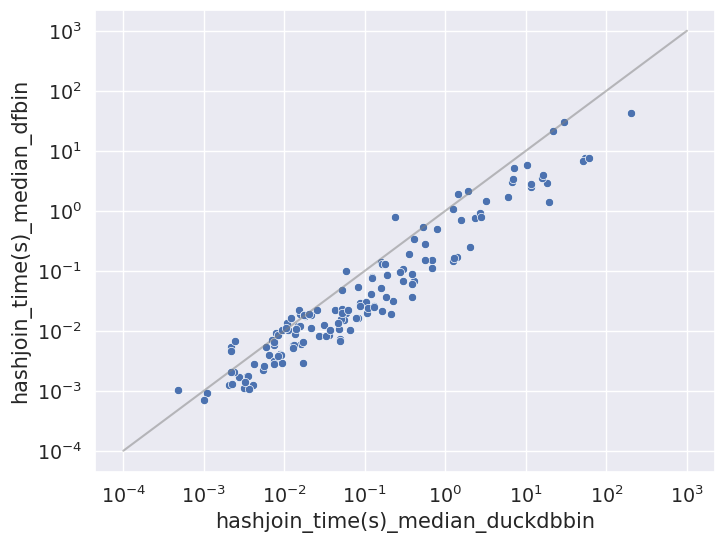

In [54]:
x = "hashjoin_time(s)_median_duckdbbin"
y = "hashjoin_time(s)_median_dfbin"
print_stats(ratio_col = merged[y] / merged[x])
scatterplot(merged, x, y)

Total: 143, epsilon: 0.01
Number of dots above the line: 21 (14.69%)
Number of dots below the line: 120 (83.92%)
Number of dots on the line 2 (1.40%)


<Axes: xlabel='duration(s)_median_duckdbbin', ylabel='duration(s)_median_dfbin'>

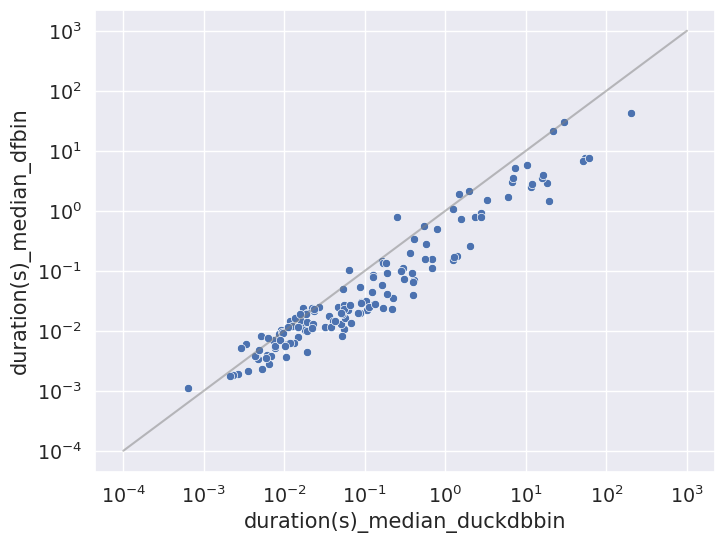

In [55]:
x = "duration(s)_median_duckdbbin"
y = "duration(s)_median_dfbin"
print_stats(ratio_col = merged[y] / merged[x])
scatterplot(merged, x, y)

## DF-Bin v.s. SYA

In [63]:
merged.loc[[49,54,126,146]][["duration(s)_median_dfbin","duration(s)_median_sya","hashjoin_time(s)_median_dfbin", "hashjoin_time(s)_median_sya"]]

,duration(s)_median_dfbin,duration(s)_median_sya,hashjoin_time(s)_median_dfbin,hashjoin_time(s)_median_sya
query,,,,
49,0.926215,0.031638,0.919529,0.028043
54,0.002126,0.002583,0.001309,0.001749
126,42.925993,5.702983,42.752297,5.632812
146,0.026405,0.032553,0.022508,0.028308


Max. slowdown:      1.336x 	(query 54, x=0.001s, y=0.002s)
Max. abs. slowdown: 0.006s 	(query 146, x=0.023s, y=0.028s)
Max. speedup:       32.790x 	(query 49, x=0.920s, y=0.028s)
Max. abs. speedup:  37.119s 	(query 126, x=42.752s, y=5.633s)
-----------------------------------------------
Total: 143, epsilon: 0.01
Number of dots above the line: 5 (3.50%)
Number of dots below the line: 138 (96.50%)
Number of dots on the line 0 (0.00%)


<Axes: xlabel='hashjoin_time(s)_median_dfbin', ylabel='hashjoin_time(s)_median_sya'>

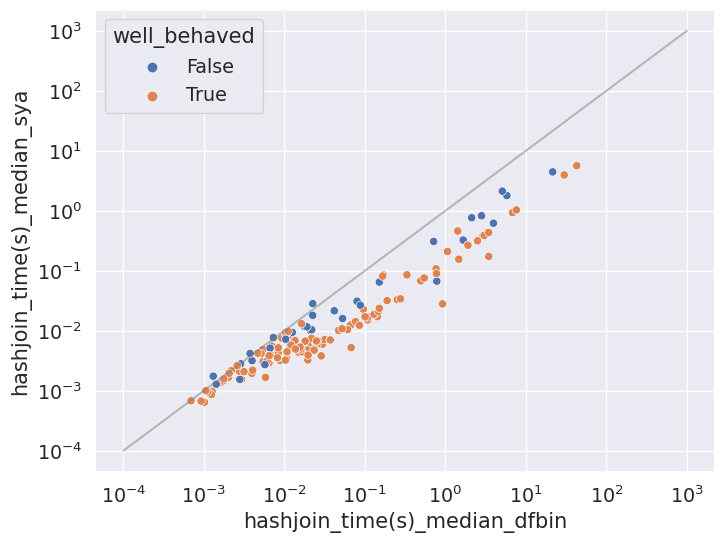

In [57]:
x = "hashjoin_time(s)_median_dfbin"
y = "hashjoin_time(s)_median_sya"

print_speedups(merged, x, y)
print_stats(ratio_col = merged[y] / merged[x])
scatterplot(merged, x, y, "well_behaved")

Max. slowdown:      1.233x 	(query 146, x=0.026s, y=0.033s)
Max. abs. slowdown: 0.006s 	(query 146, x=0.026s, y=0.033s)
Max. speedup:       29.275x 	(query 49, x=0.926s, y=0.032s)
Max. abs. speedup:  37.223s 	(query 126, x=42.926s, y=5.703s)
-----------------------------------------------
Total: 143, epsilon: 0.01
Number of dots above the line: 4 (2.80%)
Number of dots below the line: 135 (94.41%)
Number of dots on the line 4 (2.80%)


<Axes: xlabel='duration(s)_median_dfbin', ylabel='duration(s)_median_sya'>

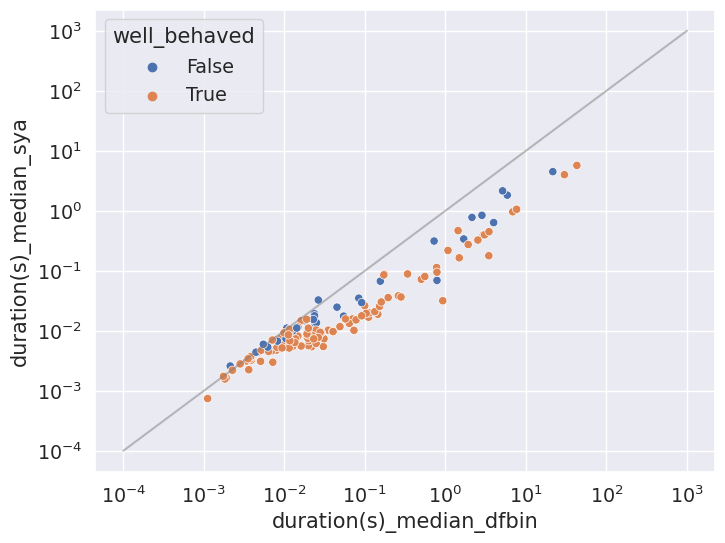

In [58]:
x = "duration(s)_median_dfbin"
y = "duration(s)_median_sya"

print_speedups(merged, x, y)
print_stats(ratio_col = merged[y] / merged[x])
scatterplot(merged, x, y, "well_behaved")

## DuckDB-Bin v.s. SYA

In [64]:
# merged.loc[[49,54,126,146]][["duration(s)_median_dfbin","duration(s)_median_sya","hashjoin_time(s)_median_dfbin", "hashjoin_time(s)_median_sya"]]

Max. slowdown:      2.240x 	(query 20, x=0.002s, y=0.005s)
Max. abs. slowdown: 0.003s 	(query 42, x=0.015s, y=0.018s)
Max. speedup:       95.863x 	(query 49, x=2.688s, y=0.028s)
Max. abs. speedup:  196.188s 	(query 126, x=201.821s, y=5.633s)
-----------------------------------------------
Total: 143, epsilon: 0.01
Number of dots above the line: 6 (4.20%)
Number of dots below the line: 136 (95.10%)
Number of dots on the line 1 (0.70%)


<Axes: xlabel='hashjoin_time(s)_median_duckdbbin', ylabel='hashjoin_time(s)_median_sya'>

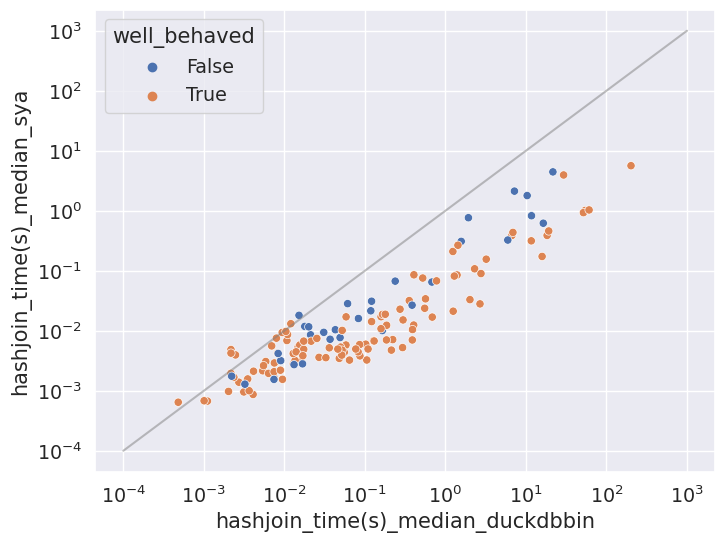

In [65]:
x = "hashjoin_time(s)_median_duckdbbin"
y = "hashjoin_time(s)_median_sya"

print_speedups(merged, x, y)
print_stats(ratio_col = merged[y] / merged[x])
scatterplot(merged, x, y, "well_behaved")

Max. slowdown:      1.683x 	(query 20, x=0.003s, y=0.006s)
Max. abs. slowdown: 0.002s 	(query 42, x=0.017s, y=0.019s)
Max. speedup:       89.229x 	(query 38, x=15.885s, y=0.178s)
Max. abs. speedup:  196.277s 	(query 126, x=201.980s, y=5.703s)
-----------------------------------------------
Total: 143, epsilon: 0.01
Number of dots above the line: 7 (4.90%)
Number of dots below the line: 135 (94.41%)
Number of dots on the line 1 (0.70%)


<Axes: xlabel='duration(s)_median_duckdbbin', ylabel='duration(s)_median_sya'>

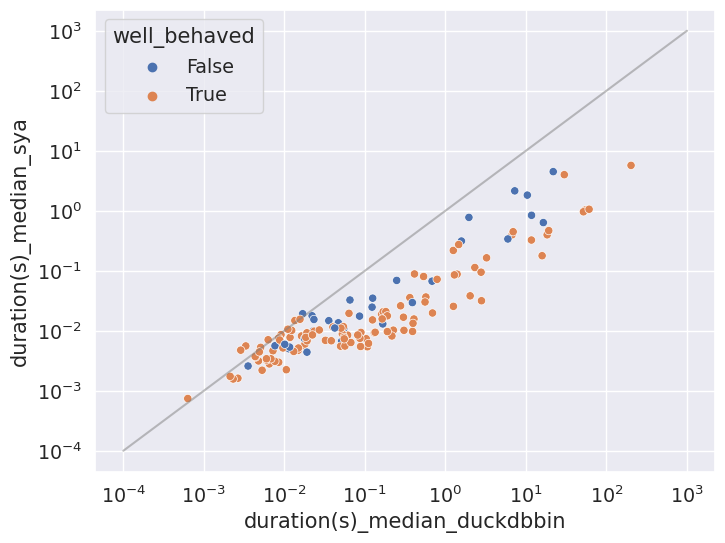

In [66]:
x = "duration(s)_median_duckdbbin"
y = "duration(s)_median_sya"

print_speedups(merged, x, y)
print_stats(ratio_col = merged[y] / merged[x])
scatterplot(merged, x, y, "well_behaved")